Number of rules per probability range:
0.6 - 0.65     10379
0.65 - 0.7     15393
0.7 - 0.75      3879
0.75 - 0.8      7963
0.8 - 0.85      7185
0.85 - 0.9      3497
0.9 - 0.95      2999
0.95 - 0.99     1542
Name: probability_range, dtype: int64


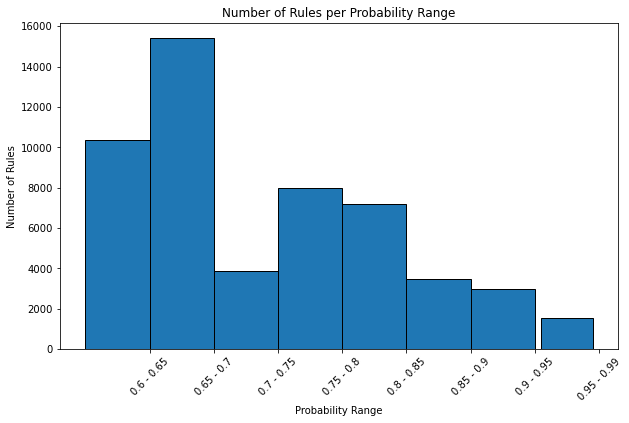

In [17]:
#plot creation - Number of Rules per Probability Range
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file into DataFrame (replace with the actual path to your CSV file)
df = pd.read_csv(
    "/home/jovyan/work/pos-to-neg-rules/rules-1000-anyb-codex",
    sep='\t',
    header=None,
    names=["score", "frequency", "probability", "rule"]
    #nrows=100
)


# probability ranges from 0.99 down to 0.6 in steps of 0.05
bins = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
labels = ['0.6 - 0.65', '0.65 - 0.7', '0.7 - 0.75', '0.75 - 0.8', '0.8 - 0.85', '0.85 - 0.9', '0.9 - 0.95', '0.95 - 0.99']

df['probability_range'] = pd.cut(df['probability'], bins=bins, labels=labels, right=False)

# Count the number of rules per probability range
rule_counts = df['probability_range'].value_counts().sort_index()

print("Number of rules per probability range:")
print(rule_counts)

# Plot the histogram using the defined bins
plt.figure(figsize=(10, 6))
plt.hist(df['probability'], bins=bins, edgecolor='black', align='left')
plt.xlabel('Probability Range')
plt.ylabel('Number of Rules')
plt.title('Number of Rules per Probability Range')
plt.xticks([0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925, 0.975], labels, rotation=45)
plt.savefig("plot.png")



In [66]:
#filter rules for every range depends on specificity threshold
import pandas as pd

# Define the probability ranges
ranges = [
    (0.95, 0.99), (0.9, 0.95), (0.85, 0.9), (0.8, 0.85), (0.75, 0.8), (0.7, 0.75), (0.65, 0.7), (0.6, 0.65)
]

# Loop through each range, read the file, filter, and save results
for lower, upper in ranges:
    # Read the CSV file for the current range
    csv_file_path = f'/home/jovyan/work/pos-to-neg-rules/output_{upper}-{lower}.csv'
    df = pd.read_csv(csv_file_path, delimiter='\t')

    # Filter rows of coverage_head
    filtered_df = df[(df['coverage_head'] >= 0.35) & (df['coverage_head'] < 0.5)]
    
    # Count the number of rows meeting the condition
    count = filtered_df.shape[0]
    print(f"Number of rows with coverage_head > 0.5 in output_{upper}-{lower}: {count}")

    output_file_path = f'/home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_{upper}-{lower}.csv'
    filtered_df.to_csv(output_file_path, sep='\t', index=False)
    print(f"Saved filtered data to {output_file_path}")


Number of rows with coverage_head > 0.5 in output_0.99-0.95: 4
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/specifity_0.99-0.95.csv
Number of rows with coverage_head > 0.5 in output_0.95-0.9: 4
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/specifity_0.95-0.9.csv
Number of rows with coverage_head > 0.5 in output_0.9-0.85: 13
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/specifity_0.9-0.85.csv
Number of rows with coverage_head > 0.5 in output_0.85-0.8: 8
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/specifity_0.85-0.8.csv
Number of rows with coverage_head > 0.5 in output_0.8-0.75: 4
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/specifity_0.8-0.75.csv
Number of rows with coverage_head > 0.5 in output_0.75-0.7: 13
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/specifity_0.75-0.7.csv
Number of rows with coverage_head > 0.5 in output_0.7-0.65: 3
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/specifity_0.7-0.65

In [68]:
#replace uris with labels to make LLMs understand the head constant of the filtered rules
import pandas as pd
import rdflib
import re

# Step 1: Load the TTL file and extract URI-to-label mappings
def load_uri_label_mapping(ttl_file):
    g = rdflib.Graph()
    g.parse(ttl_file, format='ttl')
    
    # Dictionary to store URI to label mappings
    uri_label_map = {}
    
    # Iterate over all triples and store the label associated with each URI
    for s, p, o in g.triples((None, rdflib.RDFS.label, None)):
        uri_label_map[str(s)] = str(o)
        uri_label_map["http://www.wikidata.org/prop/direct/P31"] = "instance of"
    
    return uri_label_map

# Step 2: Replace URIs with labels in the string column
def replace_uris_in_column(text, uri_label_map):
    # Regular expression for matching URIs (http or https with optional trailing slashes and complex paths)
    uri_regex = r'(http[s]?:\/\/[^\s<>\"\(\),]+)'  # This matches URIs

    # Replace URIs with their labels if they exist in the mapping
    def replace_uri(match):
        uri = match.group(0)  # Get the matched URI
        return uri_label_map.get(uri, uri)  # Return the label if found, otherwise return the original URI

    # Use re.sub() to find URIs and replace them with labels
    return re.sub(uri_regex, replace_uri, text)

# Step 3: Process the TXT file
def process_txt_file(input_file, output_file, uri_label_map, target_column_index):
    # Read the TXT file (assuming it's tab-separated)
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Process each line, replacing URIs with labels in the target column
    with open(output_file, 'w') as out_file:
        for i,line in enumerate(lines):
            if i == 0:
                continue
            columns = line.strip().split('\t')  # Split line into columns
            # Replace URIs with labels in the target column
            if len(columns) > target_column_index:

                columns[target_column_index] = replace_uris_in_column(columns[target_column_index], uri_label_map)
            # Write the modified line to the output file
            out_file.write('\t'.join(columns) + '\n')

# Load your TTL file (update with the path to your TTL file)
ttl_file = '/home/jovyan/work/pos-to-neg-rules/codexM-output.ttl'  # Replace with the actual path to your TTL file
uri_label_map = load_uri_label_mapping(ttl_file)

# Process the TXT file, specifying the target column that contains URIs
input_txt_file = '/home/jovyan/work/pos-to-neg-rules/specifity_0.65-0.6.csv'  # Replace with the actual path to your input TXT file
output_txt_file = '/home/jovyan/work/pos-to-neg-rules/labels_0.65-0.6.txt'  # Output file to store the result

# Assuming the first column contains URIs to be replaced, adjust index if needed
process_txt_file(input_txt_file, output_txt_file, uri_label_map, target_column_index=3)


In [ ]:
#sibling class determination with SPARQL
import requests
import csv
import re
import time

csv_file_path = ''
output_file_path = '/home/jovyan/work/pos-to-neg-rules/output ranges/sibling_results.txt'

sparql_endpoint = "https://qlever.cs.uni-freiburg.de/api/wikidata"

# SPARQL query template
sparql_query_template = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?siblingLabel WHERE {{
  <{head_constant}> wdt:P279 ?parentClass .
  ?sibling wdt:P279 ?parentClass .
  ?sibling rdfs:label ?siblingLabel .
  FILTER (LANG(?siblingLabel) = "en") .
  FILTER(?sibling != <{head_constant}>)
}}
"""

def extract_head_constant(rule_string):
    match = re.search(r'http://www\.wikidata\.org/entity/Q\d+', rule_string)
    if match:
        head_constant = match.group(0)
        
        return head_constant
    else:
        print(f"Head constant not found in rule: {rule_string}")
        return None

def fetch_sibling_labels(head_constant):
    sparql_query = sparql_query_template.format(head_constant=head_constant)
    

    payload = {"query": sparql_query}
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    response = requests.post(sparql_endpoint, data=payload, headers=headers)
    
    if response.status_code == 200:
        results = response.json().get("results", {}).get("bindings", [])
        sibling_labels = [result["siblingLabel"]["value"] for result in results]
        
        return sibling_labels
    else:
        print(f"Failed to retrieve data for {head_constant} (HTTP {response.status_code})")
        print("Error details:", response.text)
        return []

# Read CSV file and process each rule to get sibling labels
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=',')
    
    for row in csv_reader:
        head_constant = row["Head Constant"]
        #head_constant = extract_head_constant(rule_string)
        
        if head_constant:
            sibling_labels = fetch_sibling_labels(head_constant)
            time.sleep(1)  # Add delay to prevent rate limiting
            
            if sibling_labels:
                # Open the output file in append mode and write results
                with open(output_file_path, 'a') as output_file:
                    output_file.write(f"Head constant: {head_constant}\n")
                    output_file.write(",".join(sibling_labels) + "\n\n")
                    output_file.flush()  # Ensure data is written immediately

print(f"Results saved to {output_file_path}")
